<a href="https://colab.research.google.com/github/MNabildawami/deteksiface/blob/main/deteksiface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
pip install opencv-python dlib pandas

In [37]:
pip install --upgrade dlib

  Using cached dlib-19.24.6.tar.gz (3.4 MB)
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 423, in run
    _, build_failures = build(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 319, in build
    wheel_file = _build_one(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 193, in _build_one
    wheel_path = _build_one_inside_env(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 240, in _build_one_inside_env
    wheel_path = build_wheel_legacy(


# EKSTRASI FITUR CIRI GEOMETRI

In [50]:
import os
import cv2
import dlib
import pandas as pd
import numpy as np

# Inisialisasi deteksi wajah dan landmark dengan dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks (2).dat")  # Unduh model ini dari dlib

def extract_landmarks(image_path):
    """Ekstraksi landmark wajah dari gambar"""
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah
    faces = detector(gray)
    landmarks = []

    for face in faces:
        # Mendapatkan landmark wajah
        shape = predictor(gray, face)
        landmarks = [(shape.part(i).x, shape.part(i).y) for i in range(68)]  # 68 titik landmark
    return landmarks

def calculate_geometrical_features(landmarks):
    """Menghitung fitur geometris berdasarkan landmark"""
    features = []

    # Jarak antar mata kiri dan mata kanan (titik 36-45)
    left_eye = np.array(landmarks[36:42])  # Mata kiri (titik 36 hingga 41)
    right_eye = np.array(landmarks[42:48])  # Mata kanan (titik 42 hingga 47)

    left_eye_center = np.mean(left_eye, axis=0)
    right_eye_center = np.mean(right_eye, axis=0)
    eye_distance = np.linalg.norm(left_eye_center - right_eye_center)

    # Jarak antara hidung dan mulut (titik 27-48)
    nose = np.array(landmarks[27:36])  # Titik hidung
    mouth = np.array(landmarks[48:60])  # Titik mulut
    nose_center = np.mean(nose, axis=0)
    mouth_center = np.mean(mouth, axis=0)
    nose_mouth_distance = np.linalg.norm(nose_center - mouth_center)

    # Jarak antara kedua alis (titik 17-26)
    left_brow = np.array(landmarks[17:22])  # Alis kiri (titik 17 hingga 21)
    right_brow = np.array(landmarks[22:27])  # Alis kanan (titik 22 hingga 26)

    left_brow_center = np.mean(left_brow, axis=0)
    right_brow_center = np.mean(right_brow, axis=0)
    brow_distance = np.linalg.norm(left_brow_center - right_brow_center)

    # Jarak antara hidung dan dagu (titik 27-8)
    chin = np.array(landmarks[5:8])  # Titik dagu (titik 5 hingga 8)
    nose_chin_distance = np.linalg.norm(nose_center - chin.mean(axis=0))  # Jarak dari hidung ke dagu

    # Jarak antara sudut mulut (titik 48 dan 54)
    left_corner_of_mouth = np.array(landmarks[48])  # Sudut kiri mulut (titik 48)
    right_corner_of_mouth = np.array(landmarks[54])  # Sudut kanan mulut (titik 54)
    mouth_corners_distance = np.linalg.norm(left_corner_of_mouth - right_corner_of_mouth)

    # Menambahkan fitur ke dalam daftar
    features.extend([eye_distance, nose_mouth_distance, brow_distance, nose_chin_distance, mouth_corners_distance])

    return features

def process_images_in_directory(directory):
    """Memproses gambar dalam direktori dan sub-direktori"""
    all_features = []
    all_labels = []

    # Menelusuri semua file gambar dalam folder dan subfolder
    for subdir, _, files in os.walk(directory):
        # Ambil nama subfolder untuk digunakan sebagai label
        subfolder_name = subdir.split(os.sep)[-1]

        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_path = os.path.join(subdir, file)
                landmarks = extract_landmarks(image_path)

                if landmarks:
                    features = calculate_geometrical_features(landmarks)
                    all_features.append(features)
                    all_labels.append(subfolder_name)  # Menyimpan nama sub-folder sebagai label

    return all_features, all_labels

# Tentukan folder yang berisi gambar wajah
image_directory = "/content/drive/MyDrive/footage_pengpol /data_latih"  # Ganti dengan path folder Anda

# Ekstraksi fitur dari gambar dalam folder dan sub-folder
features, labels = process_images_in_directory(image_directory)

# Simpan fitur dan label ke dalam DataFrame
df = pd.DataFrame(features, columns=["Eye Distance", "Nose-Mouth Distance", "Brow Distance", "Nose-Chin Distance", "Mouth Corners Distance"])
df["Label"] = labels

# Simpan sebagai file CSV
df.to_csv("face_features.csv", index=False)

# Simpan sebagai file Excel
df.to_excel("face_features.xlsx", index=False)

print("Fitur geometri wajah berhasil diekstraksi dan disimpan.")


Fitur geometri wajah berhasil diekstraksi dan disimpan.


MEMBAGI 70 % DATA LATIH & 30% DATA UJI

In [51]:
import os
import random
import pandas as pd
import cv2
import dlib
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Inisialisasi deteksi wajah dan landmark dengan dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks (2).dat")  # Unduh model ini dari dlib

# Tentukan path folder yang berisi gambar-gambar dalam Google Drive
image_directory = "/content/drive/MyDrive/footage_pengpol /data_latih"  # Ganti dengan path folder Anda

# Fungsi untuk ekstraksi landmark wajah
def extract_landmarks(image_path):
    """Ekstraksi landmark wajah dari gambar"""
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah
    faces = detector(gray)
    landmarks = []

    for face in faces:
        # Mendapatkan landmark wajah
        shape = predictor(gray, face)
        landmarks = [(shape.part(i).x, shape.part(i).y) for i in range(68)]  # 68 titik landmark
    return landmarks

# Fungsi untuk menghitung fitur geometris berdasarkan landmark
def calculate_geometrical_features(landmarks):
    """Menghitung fitur geometris berdasarkan landmark"""
    features = []

    # Jarak antar mata kiri dan mata kanan (titik 36-45)
    left_eye = np.array(landmarks[36:42])  # Mata kiri (titik 36 hingga 41)
    right_eye = np.array(landmarks[42:48])  # Mata kanan (titik 42 hingga 47)

    left_eye_center = np.mean(left_eye, axis=0)
    right_eye_center = np.mean(right_eye, axis=0)
    eye_distance = np.linalg.norm(left_eye_center - right_eye_center)

    # Jarak antara hidung dan mulut (titik 27-48)
    nose = np.array(landmarks[27:36])  # Titik hidung
    mouth = np.array(landmarks[48:60])  # Titik mulut
    nose_center = np.mean(nose, axis=0)
    mouth_center = np.mean(mouth, axis=0)
    nose_mouth_distance = np.linalg.norm(nose_center - mouth_center)

    # Jarak antara kedua alis (titik 17-26)
    left_brow = np.array(landmarks[17:22])  # Alis kiri (titik 17 hingga 21)
    right_brow = np.array(landmarks[22:27])  # Alis kanan (titik 22 hingga 26)

    left_brow_center = np.mean(left_brow, axis=0)
    right_brow_center = np.mean(right_brow, axis=0)
    brow_distance = np.linalg.norm(left_brow_center - right_brow_center)

    # Jarak antara hidung dan dagu (titik 27-8)
    chin = np.array(landmarks[5:8])  # Titik dagu (titik 5 hingga 8)
    nose_chin_distance = np.linalg.norm(nose_center - chin.mean(axis=0))  # Jarak dari hidung ke dagu

    # Jarak antara sudut mulut (titik 48 dan 54)
    left_corner_of_mouth = np.array(landmarks[48])  # Sudut kiri mulut (titik 48)
    right_corner_of_mouth = np.array(landmarks[54])  # Sudut kanan mulut (titik 54)
    mouth_corners_distance = np.linalg.norm(left_corner_of_mouth - right_corner_of_mouth)

    # Menambahkan fitur ke dalam daftar
    features.extend([eye_distance, nose_mouth_distance, brow_distance, nose_chin_distance, mouth_corners_distance])

    return features

# Fungsi untuk membagi gambar menjadi data latih dan data uji
def split_images_into_train_test(image_directory, train_size=7, test_size=3):
    all_train_images = []
    all_train_labels = []
    all_train_features = []

    all_test_images = []
    all_test_labels = []
    all_test_features = []

    # Menelusuri semua sub-folder dalam folder image_directory
    for subdir, _, files in os.walk(image_directory):
        # Ambil nama subfolder untuk digunakan sebagai label
        subfolder_name = os.path.basename(subdir)  # Mendapatkan nama subfolder

        # Mengambil file gambar yang ada dalam sub-folder
        image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

        # Membagi gambar menjadi train dan test (7 untuk latih dan 3 untuk uji)
        random.shuffle(image_files)  # Shuffle gambar secara acak

        train_images = image_files[:train_size]
        test_images = image_files[train_size:train_size + test_size]

        # Menambahkan gambar latih dan fitur ke dalam list data latih
        for image in train_images:
            image_path = os.path.join(subdir, image)
            landmarks = extract_landmarks(image_path)

            if landmarks:
                features = calculate_geometrical_features(landmarks)
                all_train_images.append(image)
                all_train_labels.append(subfolder_name)  # Menggunakan nama subfolder sebagai label
                all_train_features.append(features)  # Menyimpan fitur wajah

        # Menambahkan gambar uji dan fitur ke dalam list data uji
        for image in test_images:
            image_path = os.path.join(subdir, image)
            landmarks = extract_landmarks(image_path)

            if landmarks:
                features = calculate_geometrical_features(landmarks)
                all_test_images.append(image)
                all_test_labels.append(subfolder_name)  # Menggunakan nama subfolder sebagai label
                all_test_features.append(features)  # Menyimpan fitur wajah

    return all_train_images, all_train_labels, all_train_features, all_test_images, all_test_labels, all_test_features

# Ambil gambar dari sub-folder, bagi menjadi data latih dan data uji, serta ekstraksi fitur wajah
train_images, train_labels, train_features, test_images, test_labels, test_features = split_images_into_train_test(image_directory)

# Simpan data latih dalam DataFrame dan kemudian simpan ke CSV tanpa kolom 'Image'
train_df = pd.DataFrame(train_features, columns=["Eye Distance", "Nose-Mouth Distance", "Brow Distance", "Nose-Chin Distance", "Mouth Corners Distance"])
train_df['Label'] = train_labels  # Menambahkan kolom Label

# Simpan data uji dalam DataFrame dan kemudian simpan ke CSV tanpa kolom 'Image'
test_df = pd.DataFrame(test_features, columns=["Eye Distance", "Nose-Mouth Distance", "Brow Distance", "Nose-Chin Distance", "Mouth Corners Distance"])
test_df['Label'] = test_labels  # Menambahkan kolom Label

# Simpan sebagai file CSV tanpa kolom 'Image'
train_df.to_csv("data_latih.csv", index=False)
test_df.to_csv("data_uji.csv", index=False)

print("Pembagian gambar menjadi data latih dan uji selesai. File CSV tanpa kolom 'Image' telah disimpan.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Pembagian gambar menjadi data latih dan uji selesai. File CSV tanpa kolom 'Image' telah disimpan.


METODE KLASIFIKASI BPNN

In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Load datasets
train_file = 'data_latih.csv'  # Training dataset
test_file = 'data_uji.csv'  # Testing dataset

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

# Extract features and labels from training data
features = ["Eye Distance", "Nose-Mouth Distance", "Brow Distance", "Nose-Chin Distance", "Mouth Corners Distance"]
x_train = df_train[features].values
y_train = df_train['Label'].values

# Encode species labels to integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

# Normalize feature values
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(df_test[features].values)

# Define the neural network structure
n_inputs = len(features)
n_hidden = 5  # Number of hidden neurons
n_outputs = len(set(y_train))  # Number of unique labels
l_rate = 0.3  # Learning rate
n_epoch = 500  # Number of epochs

# Initialize network
def initialize_network(n_inputs, n_hidden, n_outputs):
    network = [
        [{'weights': np.random.rand(n_inputs + 1)} for _ in range(n_hidden)],  # Input layer to hidden layer
        [{'weights': np.random.rand(n_hidden + 1)} for _ in range(n_outputs)]  # Hidden layer to output layer
    ]
    return network

# Activation function (Sigmoid)
def sigmoid(x, derivative=False):
    if derivative:
        return x * (1.0 - x)
    return 1.0 / (1.0 + np.exp(-x))

# Forward propagation
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = neuron['weights'][-1] + np.dot(neuron['weights'][:-1], inputs)
            neuron['output'] = sigmoid(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs

# Backward propagation of error
def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = []
        if i != len(network) - 1:
            for j in range(len(layer)):
                error = sum([neuron['weights'][j] * neuron['delta'] for neuron in network[i + 1]])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * sigmoid(neuron['output'], derivative=True)

# Update weights
def update_weights(network, row, l_rate):
    for i in range(len(network)):
        inputs = row[:-1] if i == 0 else [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] += l_rate * neuron['delta']

# Train the network
def train_network(network, train, l_rate, n_epoch, n_outputs):
    for epoch in range(n_epoch):
        for row in train:
            outputs = forward_propagate(network, row[:-1])
            expected = [0 for _ in range(n_outputs)]
            expected[int(row[-1])] = 1  # One-hot encode the expected output
            backward_propagate_error(network, expected)
            update_weights(network, row, l_rate)

# Make a prediction
def predict(network, row):
    outputs = forward_propagate(network, row)
    return outputs.index(max(outputs))  # Return the index with the highest output

# Prepare training data
train_data = np.column_stack((x_train, y_train.astype(int)))  # Add labels to the features
network = initialize_network(n_inputs, n_hidden, n_outputs)

# Train the model
train_network(network, train_data, l_rate, n_epoch, n_outputs)

# Predict on test data
predictions = [predict(network, row) for row in x_test]
predicted_labels = label_encoder.inverse_transform(predictions)

# Save predictions
df_test['Predicted_Label'] = predicted_labels
df_test.to_csv('predictions.csv', index=False)

print("Predictions saved to 'predictions.csv'")


Predictions saved to 'predictions.csv'


Tingkat keakuratan metode klasifikasi: 100.00%


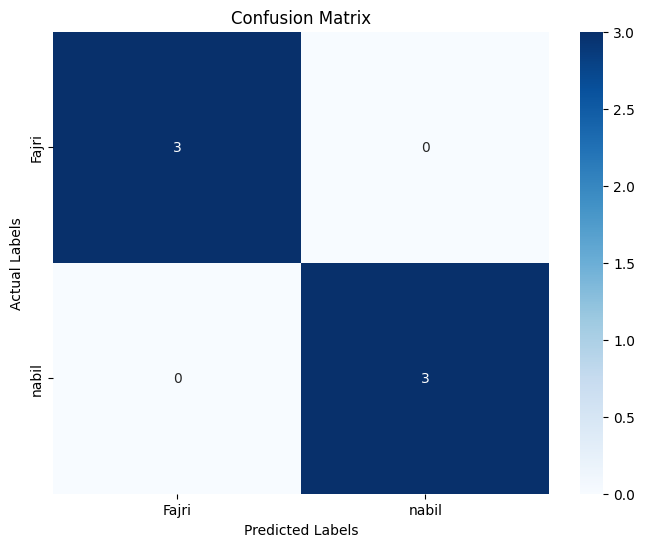

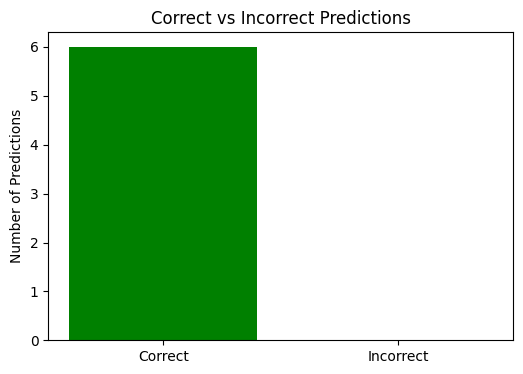

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the actual output and predicted output files
actual_file = 'data_uji.csv'  # File with actual labels
predicted_file = 'predictions.csv'  # File with predicted labels

df_actual = pd.read_csv(actual_file)
df_predicted = pd.read_csv(predicted_file)

# Extract the columns of interest
actual_labels = df_actual['Label']
predicted_labels = df_predicted['Predicted_Label']

# Compare actual and predicted labels
correct_predictions = (actual_labels == predicted_labels).sum()
total_predictions = len(actual_labels)

# Calculate accuracy
accuracy = (correct_predictions / total_predictions) * 100
print(f'Tingkat keakuratan metode klasifikasi: {accuracy:.2f}%')

# --- Confusion Matrix Visualization ---
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot Confusion Matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

# --- Bar Plot for Correct vs Incorrect Predictions ---
incorrect_predictions = total_predictions - correct_predictions
labels = ['Correct', 'Incorrect']
values = [correct_predictions, incorrect_predictions]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['green', 'red'])
plt.title('Correct vs Incorrect Predictions')
plt.ylabel('Number of Predictions')
plt.show()

